In [110]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime
major_forex_pairs

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']

In [111]:
freq = 'm15'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
ticker = major_forex_pairs[1]
print(ticker)
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data)
test_size = 0.048
test_len = int(test_size * len(data))

GBP/USD


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-16 12:00:00,1.38120,1.38360,1.38387,1.38119,1.38135,1.38373,1.38401,1.38135,2581,1.381275,1.383940,1.381270,1.383665
2021-07-16 12:15:00,1.38360,1.38159,1.38387,1.38159,1.38373,1.38202,1.38397,1.38181,2854,1.383665,1.383920,1.381700,1.381805
2021-07-16 12:30:00,1.38159,1.38197,1.38235,1.38128,1.38202,1.38212,1.38251,1.38141,5833,1.381805,1.382430,1.381345,1.382045
2021-07-16 12:45:00,1.38197,1.38077,1.38219,1.38073,1.38212,1.38094,1.38234,1.38089,2948,1.382045,1.382265,1.380810,1.380855
2021-07-16 13:00:00,1.38077,1.38195,1.38195,1.38040,1.38094,1.38208,1.38209,1.38056,3672,1.380855,1.382020,1.380480,1.382015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 11:30:00,1.31966,1.31841,1.32005,1.31595,1.31983,1.31855,1.32020,1.31614,4761,1.319745,1.320125,1.316045,1.318480
2021-12-08 11:45:00,1.31840,1.32137,1.32226,1.31789,1.31854,1.32153,1.32243,1.31802,9369,1.318470,1.322345,1.317955,1.321450
2021-12-08 12:00:00,1.32136,1.31880,1.32148,1.31836,1.32153,1.31898,1.32165,1.31851,5009,1.321445,1.321565,1.318435,1.318890


In [112]:
periods = (5, 50)
data['EMA1'] = talib.EMA(data['close'], periods[0])
data['EMA2'] = talib.EMA(data['close'], periods[1])

In [113]:
data['signal'] = np.where(data['EMA1'] > data['EMA2'], 1,
                          np.where(data['EMA2'] > data['EMA1'], -1, np.nan))

In [114]:
if data.shape[0] > test_len:
    data = data.iloc[-test_len:]
else:
    pass

data['signal'] = data['signal'].ffill().fillna(0).mul(-1)
print('*** Positions ***')
print(data['signal'].value_counts())
print('-'*50)
print('*** Trades ***')
print(data['signal'].diff(1).apply(np.abs).value_counts())

*** Positions ***
 1.0    302
-1.0    178
Name: signal, dtype: int64
--------------------------------------------------
*** Trades ***
0.0    466
2.0     13
Name: signal, dtype: int64


  0%|          | 0/479 [00:00<?, ?it/s]

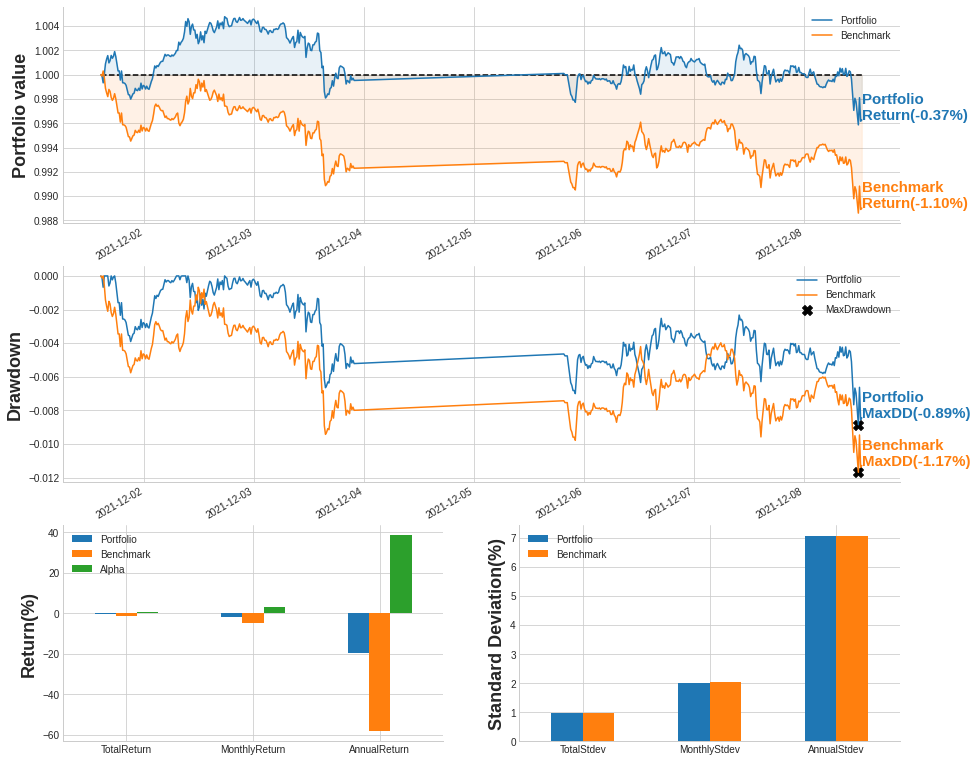

----------------------------------------------------------------------
Data length: |6 days 22:00:00|
Data range from |2021-12-01 14:30:00| to |2021-12-08 12:30:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -0.374 │      -1.107 │   0.733 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -1.622 │      -4.801 │   3.179 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │     -19.734 │     -58.414 │  38.679 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │    

In [115]:
backtest = IterativeBacktester(data=data,
                               signals=data['signal'],
                               freq=freq)
backtest.backtest()
backtest.results()